# Imports

In [113]:
import pandas as pd
# import logging
import numpy as np
import statsmodels.api as sm
from matplotlib.pyplot import twinx
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# logger = logging.getLogger(__name__)



# Functions Library

In [26]:
def read_data() -> tuple[pd.Series, pd.Series]:
    PATH = r"C:\Users\pcampos\OneDrive - Insper - Instituto de Ensino e Pesquisa\Dissertação Mestrado\base\BR CDS and FX.xlsx"
    sheet_name = "BRL"
    sheet_name2 = "Brazil CDS"
    fx = pd.read_excel(PATH, index_col=0, sheet_name=sheet_name).iloc[:, 0]
    cds = pd.read_excel(PATH, index_col=0, sheet_name=sheet_name2).iloc[:, 0]
    fx.index = pd.to_datetime(fx.index)
    fx.name = sheet_name
    cds.index = pd.to_datetime(cds.index)
    cds.name = sheet_name2
    return fx, cds


def filter_by_period(df: pd.DataFrame, period: str) -> pd.DataFrame:
    new_index = (
        pd.DatetimeIndex(  # TODO: add check for last date, if should be included or not
            df.index.to_series().groupby(df.index.to_period(period)).max()
        )
    )
    return df.loc[new_index].copy()


def _calculate_parameters(y: pd.Series, x: pd.Series) -> pd.Series:
    model = sm.OLS(y, sm.add_constant(x)).fit()
    s_params = model.params.copy()
    s_params.index = [
        "alpha" if idx == "const" else f"beta_{idx}" for idx in s_params.index
    ]
    return s_params

def _percentage_formatter(x, _):
    return f"{x * 100:.1f}%"

# Prepare data

## Generate Return Series 

In [122]:
ENDOG_COL = "BRL"
EXOG_COLS = ["Brazil CDS"]
(s_index_fx, s_index_cds) = read_data()


list_series = [s_index_cds, s_index_fx]

df_indexes = pd.concat(list_series, axis=1, join="outer").fillna(method="ffill")
df_indexes.index.name = None
df_indexes.columns = EXOG_COLS + [ENDOG_COL]


df_period = filter_by_period(df_indexes, "D")

df_return_ln = np.log(df_period / df_period.shift(1)).dropna().copy()
df_return = (df_period / df_period.shift(1) - 1).dropna().copy()
df_return_ln

,Brazil CDS,BRL
2007-08-08,0.004515,0.012847
2007-08-09,-0.006302,-0.013849
2007-08-10,-0.001671,-0.023582
2007-08-13,0.003102,0.008677
2007-08-14,-0.004417,-0.018366
...,...,...
2024-05-20,0.000455,0.004086
2024-05-21,-0.000379,-0.003153
2024-05-22,-0.001365,-0.008490
2024-05-23,-0.001671,0.000464


## Estimate Parameters

In [123]:
# Parameters:
# starting point: 252 observations
# expaning window beta

N_MIN = 252

N_MAX = len(df_return_ln.index)

aux_params = {}

for n in range(N_MIN, N_MAX + 1):

    sub_df = df_return_ln.iloc[:n].copy()

    param = _calculate_parameters(sub_df[ENDOG_COL], sub_df[EXOG_COLS])

    ref_date = sub_df.index[-1]
    aux_params[ref_date] = param.to_dict()


df_params = pd.DataFrame(aux_params).T

# Trading Strategy

In [217]:
COL_TIMEFRAME_NBR = "timeframe_nbr"
COL_EXPECTED_RETURN_ACC = "expected_return_acc"
COL_REALIZED_RETURN_ACC = "realized_return_acc"
COL_OUTPERFORMANCE_RETURN_ACC = "outperformance_return_acc"
COL_OUTPERFORMANCE_RETURN_LN_ACC = "outperformance_return_ln_acc"
COL_OUTPERFORMANCE_RETURN_LN = "outperformance_return_ln"
COL_SIGNAL = "signal"
COL_ALPHA = "alpha"

def _get_reblance_trades() -> pd.DatetimeIndex:
    N_DAYS = 63
    return df_trading_period.index[::N_DAYS].copy()

df_aux = pd.concat([df_return_ln, df_params], axis=1)
rebalance_dates = _get_reblance_trades()
df_aux[COL_TIMEFRAME_NBR] = (
    df_aux.index.to_series().isin(rebalance_dates).shift(1).cumsum().fillna(0)
)
df_trading_period = df_aux.dropna().copy()

cols_betas = [f"beta_{col}" for col in EXOG_COLS]
list_df_outperformance = []
first_signal = 1
for timeframe, sub_df in df_trading_period.groupby(COL_TIMEFRAME_NBR):
    if timeframe == 0:
        signal = first_signal # FIXME
        s_est_betas_previous = sub_df[cols_betas].iloc[-1]
        est_alpha_previous = sub_df["alpha"].iloc[-1]
        continue

    # print(
    #     f"Timeframe: #{timeframe:02.0f}  |  Signal: {'On' if signal else 'Off': <3}  |  "
    # )
    df_ln_returns_acc = sub_df[EXOG_COLS].cumsum().copy()
    df_returns_acc = np.exp(df_ln_returns_acc) - 1
    df_beta_returns_acc = pd.DataFrame(
        df_returns_acc.sort_index(axis=1).values
        * s_est_betas_previous.sort_index().values,
        index=df_returns_acc.index,
        columns=df_returns_acc.columns.sort_values(),
    )
    s_expected_returns_acc = df_beta_returns_acc.sum(axis=1) # TODO: how to incorporate alpha in expected returns?
    s_expected_returns_acc.name = COL_EXPECTED_RETURN_ACC
    s_realized_returns_acc = np.exp(sub_df[ENDOG_COL].cumsum()) - 1
    s_realized_returns_acc.name = COL_REALIZED_RETURN_ACC
    s_outperformance_acc = s_realized_returns_acc - s_expected_returns_acc
    s_outperformance_acc.name = COL_OUTPERFORMANCE_RETURN_ACC
    s_outperformance_ln_acc = np.log(1 + s_outperformance_acc)
    s_outperformance_ln_acc.name = COL_OUTPERFORMANCE_RETURN_LN_ACC
    s_outperformance_ln = s_outperformance_ln_acc - s_outperformance_ln_acc.shift(
        1
    ).fillna(0)
    s_outperformance_ln.name = COL_OUTPERFORMANCE_RETURN_LN

    s_est_betas_previous = sub_df[cols_betas].iloc[-1]
    est_alpha_previous = sub_df[COL_ALPHA].iloc[-1]
    sub_df_outperformance = pd.concat(
        [
            s_expected_returns_acc,
            s_realized_returns_acc,
            s_outperformance_acc,
            s_outperformance_ln_acc,
            s_outperformance_ln,
        ],
        axis=1,
    )
    sub_df_outperformance[COL_SIGNAL] = signal
    list_df_outperformance.append(sub_df_outperformance)
    signal = 1 if s_outperformance_acc.iloc[-1] > 0 else -1
    # if timeframe == 1:
    #     break

df_outperformance = pd.concat(list_df_outperformance)
df_outperformance

,expected_return_acc,realized_return_acc,outperformance_return_acc,outperformance_return_ln_acc,outperformance_return_ln,signal
2008-08-08,-0.002547,-0.016786,-0.014240,-0.014342,-0.014342,1
2008-08-11,0.000000,-0.014287,-0.014287,-0.014390,-0.000049,1
2008-08-12,-0.000637,-0.020966,-0.020329,-0.020539,-0.006148,1
2008-08-13,-0.000637,-0.023500,-0.022864,-0.023129,-0.002590,1
2008-08-14,-0.000637,-0.014261,-0.013624,-0.013718,0.009411,1
...,...,...,...,...,...,...
2024-05-20,0.002151,-0.013683,-0.015834,-0.015961,0.003437,-1
2024-05-21,0.001613,-0.016788,-0.018401,-0.018573,-0.002612,-1
2024-05-22,-0.000323,-0.025100,-0.024777,-0.025089,-0.006517,-1
2024-05-23,-0.002689,-0.024648,-0.021959,-0.022204,0.002885,-1


In [221]:
df_base.to_clipboard()

In [219]:
df_base = pd.concat([df_aux, df_outperformance], axis=1)
df_base.to_excel(
    r"C:\Users\pcampos\OneDrive - Insper - Instituto de Ensino e Pesquisa\Dissertação Mestrado\base\testing.xlsx"
)

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\pcampos\\OneDrive - Insper - Instituto de Ensino e Pesquisa\\Dissertação Mestrado\\base\\testing.xlsx'

# Analysis

## Plot regression parameters

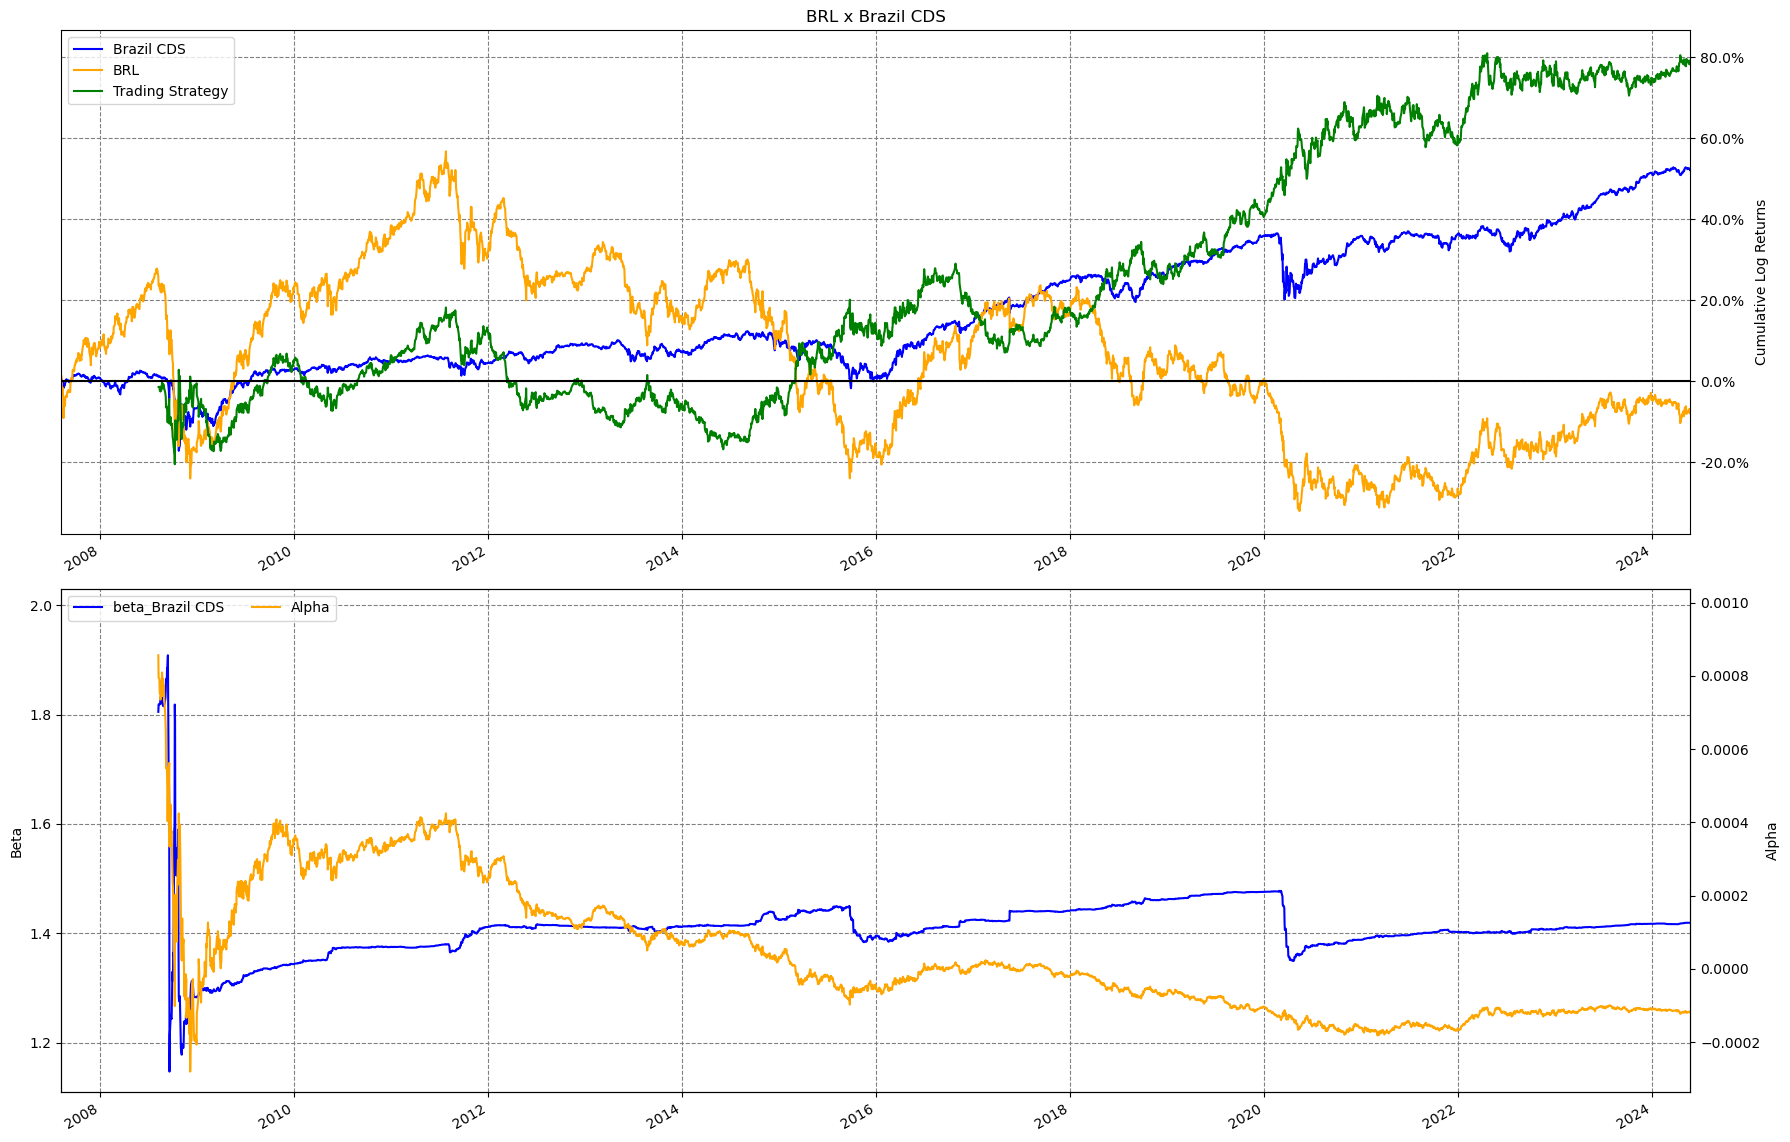

In [211]:
# plot return
fig, axes = plt.subplots(figsize=(18, 12), nrows=2)

axes[0].set_title("BRL x Brazil CDS")
((1 + df_aux.iloc[:, :2]).cumprod() - 1).plot(ax=axes[0], color=["blue", "orange"])
(
    df_outperformance[COL_OUTPERFORMANCE_RETURN_LN] * df_outperformance[COL_SIGNAL]
).cumsum().plot(
    ax=axes[0], label="Trading Strategy", color="green"
)
axes[0].legend()

# Add gridlines to the first plot
axes[0].grid(True, color="gray", linestyle="--")

# Add a horizontal line at y=0 to the first plot
axes[0].axhline(y=0, color="black")

# Move the y-axis label and ticks to the right for the first plot
axes[0].yaxis.set_label_position("right")
axes[0].yaxis.tick_right()
axes[0].set_ylabel("Cumulative Log Returns")

# Apply the percentage formatter to the first plot
axes[0].yaxis.set_major_formatter(FuncFormatter(_percentage_formatter))

# Set x-axis limits to the first and last data points
axes[0].set_xlim(df_aux.index.min(), df_aux.index.max())

# beta and alpha plot
for beta_col in cols_betas:
    df_aux[beta_col].plot(ax=axes[1], color="blue", label=beta_col)
ax2 = axes[1].twinx()
df_aux["alpha"].plot(ax=ax2, color="orange", label="Alpha")

# Add gridlines to the second plot
axes[1].grid(True, color="gray", linestyle="--")

# Set y-axis labels
axes[1].set_ylabel("Beta")
ax2.set_ylabel("Alpha")

# Set x-axis limits to the first and last data points
axes[1].set_xlim(df_aux.index.min(), df_aux.index.max())

y_min, y_max = axes[1].get_ylim()
y_range = y_max - y_min
y_mid = (y_max + y_min)/2
axes[1].set_ylim(y_mid - y_range / 2, y_mid + y_range / 2 * 1.2)

y_min, y_max = ax2.get_ylim()
y_range = y_max - y_min
y_mid = (y_max + y_min) / 2
ax2.set_ylim(y_mid - y_range / 2, y_mid + y_range / 2 * 1.2)

# Combine legends from both axes
lines1, labels1 = axes[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axes[1].legend(lines1 + lines2, labels1 + labels2, loc="upper left", ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to make space for the title

plt.show()
plt.close()

In [ ]:
(
    df_outperformance[COL_OUTPERFORMANCE_RETURN_LN] * df_outperformance[COL_SIGNAL]
).cumsum().plot()
(df_outperformance[COL_OUTPERFORMANCE_RETURN_LN]).cumsum().plot()